In [50]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

### 第一步：加载资源数据集

In [51]:
data_raw = pd.read_csv(".././data/RandomTreeData/train.csv")
data_val = pd.read_csv(".././data/RandomTreeData/test.csv")

In [52]:
# 列名转换为小写格式
data_raw.columns = data_raw.columns.str.lower() #转换为小写
data_val.columns = data_val.columns.str.lower() #转换为小写
data_raw.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: ylabel='count'>

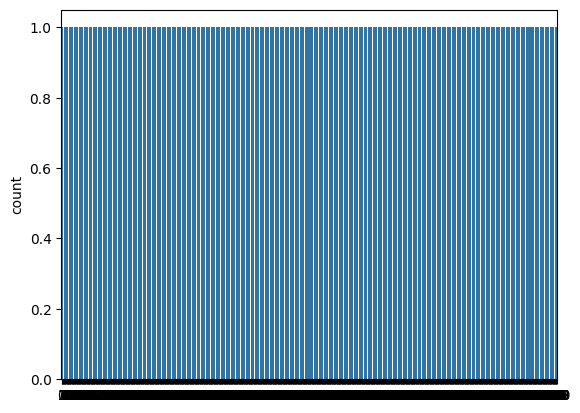

In [53]:
# 绘制图形
sns.countplot(data_raw["survived"])

In [54]:
# 合并两个数据集一并清洗
data_all = [data_raw,data_val]

### 第二步：数据清洗

In [55]:
data_all[0].isnull().sum() # 查看训练集中的空值

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [56]:
data_all[1].isnull().sum() # 查看验证集中的空值

passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

In [57]:
# 对源数据集进行描述
data_all[0].describe(include='all')

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [58]:
# 对原始数据集(训练集+验证集)进行清理
for dataset in data_all:
    # 补足空缺值
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['fare']= dataset['fare'].fillna(dataset['fare'].median())
    dataset['embarked'] =dataset['embarked'].fillna(dataset['embarked'].mode()[0]) # mode()取出现频率较高的字符返回的是数组

In [59]:
# 删除字段
drop_columns = ['passengerid','cabin','ticket']
data_all[0] = data_all[0].drop(drop_columns,axis=1)
data_all[1] = data_all[1].drop(drop_columns,axis=1)

In [60]:
data_all[0].isnull().sum() # 训练集

survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

In [61]:
data_all[1].isnull().sum() # 验证集

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

### 第三步：特征信息构建

In [62]:
    for dataset in data_all:
        # 构建新的字段:
        # （1）family_size 家庭规模：sibsp + parch
        dataset['family_size'] = dataset['sibsp'] + dataset['parch'] + 1 # 家庭规模默认为0加上自己 
        # （2）单身 single 1:单身，0：非单身
        dataset['single'] = 1 
        dataset.loc[dataset['family_size'] > 1,'single'] = 0 # 0：不是单身
        # （3）身份 title
        #  dataset['title'] = dataset['name'].str.split(', ',expand=True)[1].str.split('.',expand=True)[0]
        dataset['title'] = dataset['name'].apply(lambda x:x.split(",")[1]).apply(lambda x:x.split('.')[0])
        # （4）票价 fare_bin
        dataset['fare_bin'] = pd.qcut(dataset['fare'],4) # 根据票价，分成4组（其中每一组的元素个数一致）
        # （5）年龄 age_bin
        dataset['age_bin'] = pd.qcut(dataset['age'].astype(int),4) # 根据年龄分组，分成四组 （其中每一组的元素个数一致）

In [63]:
title_names = data_all[0]['title'].value_counts() < 10

In [64]:
title_names

title
Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Major            True
Ms               True
Mme              True
Don              True
Lady             True
Sir              True
Capt             True
the Countess     True
Jonkheer         True
Name: count, dtype: bool

In [65]:
# title: 将那些称谓的人数小于10的数据，全部归为一类：other
data_all[0]['title'] = data_all[0]['title'].apply(lambda x: 'other' if title_names[x] else x)

In [66]:
data_all[0]['title'].value_counts()

title
 Mr        517
 Miss      182
 Mrs       125
 Master     40
other       27
Name: count, dtype: int64

In [67]:
# 计算每种身份的获救概率
data_all[0]['survived'].groupby(data_all[0]['title']).mean()

title
 Master    0.575000
 Miss      0.697802
 Mr        0.156673
 Mrs       0.792000
other      0.444444
Name: survived, dtype: float64

### （二）构建新的字段，基于scikit-learn中的LabelEncoder()

In [68]:
data_all[0].head()


,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family_size,single,title,fare_bin,age_bin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(-0.001, 22.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(35.0, 80.0]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,0,Miss,"(7.91, 14.454]","(22.0, 28.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(28.0, 35.0]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,0,Mr,"(7.91, 14.454]","(28.0, 35.0]"


In [69]:
label = LabelEncoder()

In [70]:
for dataset in data_all:
    # （1）新字段：sex_code
    dataset['sex_code'] = label.fit_transform(dataset['sex']) 
    # （2）新字段：embarked_code
    dataset['embarked_code'] = label.fit_transform(dataset['embarked'])
    # （3）新字段：title_code
    dataset['title_code'] = label.fit_transform(dataset['title'])
    # （4）新字段：age_bin_code
    dataset['age_bin_code'] = label.fit_transform(dataset['age_bin'])
    # （5）新字段：fare_bin_code
    dataset['fare_bin_code'] = label.fit_transform(dataset['fare_bin'])

In [71]:
data_all[0].head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family_size,single,title,fare_bin,age_bin,sex_code,embarked_code,title_code,age_bin_code,fare_bin_code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(-0.001, 22.0]",1,2,2,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(35.0, 80.0]",0,0,3,3,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,0,Miss,"(7.91, 14.454]","(22.0, 28.0]",0,2,1,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(28.0, 35.0]",0,2,3,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,0,Mr,"(7.91, 14.454]","(28.0, 35.0]",1,2,2,2,1


In [72]:
# 列的名称
data_all[0].columns.tolist()

['survived',
 'pclass',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'family_size',
 'single',
 'title',
 'fare_bin',
 'age_bin',
 'sex_code',
 'embarked_code',
 'title_code',
 'age_bin_code',
 'fare_bin_code']

### 方式一：特征选择


In [73]:
Target = ['survived'] # 标签

In [74]:
data_columns_one = ['sex','pclass','embarked','title','sibsp','parch','fare','age','family_size','single']
clumns_one = Target + data_columns_one

### 方式二：特征选择


In [75]:
data_columns_two = ['sex_code','pclass','embarked_code','title_code','age','sibsp','parch','fare']
clumns_two = Target + data_columns_two

### 方式三：特征选择


In [76]:
data_columns_three = ['sex_code','pclass','embarked_code','title_code','family_size','age_bin_code','fare_bin_code']
clumns_three = Target + data_columns_three

### 通过pandas中的get_dummies()进行编码转换

In [77]:
data_one_dummy = pd.get_dummies(data_all[0][data_columns_one])
data_one_dummy_list = data_one_dummy.columns.tolist()

In [78]:
data_one_dummy_list

['pclass',
 'sibsp',
 'parch',
 'fare',
 'age',
 'family_size',
 'single',
 'sex_female',
 'sex_male',
 'embarked_C',
 'embarked_Q',
 'embarked_S',
 'title_ Master',
 'title_ Miss',
 'title_ Mr',
 'title_ Mrs',
 'title_other']

### 方式一：获取训练集和测试集

In [79]:
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(data_one_dummy[data_one_dummy_list],data_all[0][Target],random_state=0)
X_train_one.shape

(668, 17)

In [80]:
X_test_one.shape

(223, 17)

### 方式二：获取训练集和测试集

In [81]:
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(data_all[0][data_columns_two],data_all[0][Target],random_state=0)
X_train_two.shape

(668, 8)

In [82]:
X_test_two.shape

(223, 8)

### 方式三：获取训练集和测试集

In [83]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(data_all[0][data_columns_three],data_all[0][Target],random_state=0)
X_train_three.shape

(668, 7)

In [84]:
X_test_three.shape

(223, 7)

### 随机森林算法实现

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [86]:
rf = RandomForestClassifier(random_state=1,n_jobs=-1)

In [87]:
# 网格搜索
param_gird = {
    'criterion':['gini','entropy'],
    'min_samples_leaf':[1,5,10],
    'min_samples_split':[2,4,10,12,16],
    'n_estimators':[50,100,400,700,1000]
}

In [88]:
gs = GridSearchCV(estimator=rf,param_grid=param_gird,scoring='accuracy',cv=3,n_jobs=-1)

### 特征一训练

In [89]:
gs.fit(X_train_one,y_train_one)

D:\PyDemo\T8-jupyte\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 4, 10, 12, 16],
                         'n_estimators': [50, 100, 400, 700, 1000]},
             scoring='accuracy')

In [90]:
print(gs.best_score_)

0.8323704870790073


In [91]:
# 网格搜索最优配置
print(gs.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 400}


In [92]:
rf2 = RandomForestClassifier(criterion='entropy',
                            min_samples_leaf=5,
                            min_samples_split=16,
                            n_estimators=400,
                            n_jobs=-1,
                            random_state=1)

In [93]:
rf2.fit(X_train_one,y_train_one)

D:\PyDemo\T8-jupyte\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', min_samples_leaf=5,
                       min_samples_split=16, n_estimators=400, n_jobs=-1,
                       random_state=1)

### 预测数据

In [94]:
X_train_one.head()

,pclass,sibsp,parch,fare,age,family_size,single,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_ Master,title_ Miss,title_ Mr,title_ Mrs,title_other
105,3,0,0,7.8958,28.0,1,0,False,True,False,False,True,False,False,True,False,False
68,3,4,2,7.9250,17.0,7,0,True,False,False,False,True,False,True,False,False,False
253,3,1,0,16.1000,30.0,2,0,False,True,False,False,True,False,False,True,False,False
320,3,0,0,7.2500,22.0,1,0,False,True,False,False,True,False,False,True,False,False
706,2,0,0,13.5000,45.0,1,0,True,False,False,False,True,False,False,False,True,False


In [95]:
# 根据特征重要性进行排序
pd.concat((pd.DataFrame(X_train_one.iloc[:,1:].columns,columns=['Variable']),
           pd.DataFrame(rf2.feature_importances_,columns=['importance'])),axis=1).sort_values(by='importance',ascending=False)

,Variable,importance
14,title_ Mrs,0.177227
3,age,0.145433
7,sex_male,0.134735
8,embarked_C,0.120574
4,family_size,0.099986
0,sibsp,0.098204
5,single,0.057345
1,parch,0.036882
15,title_other,0.033222
13,title_ Mr,0.027845


### 测试集上预测


In [96]:
pred = rf2.predict(X_test_one)

In [97]:
pred_df = pd.DataFrame(pred,columns=['svrived'])

In [98]:
pred_df.head()

,svrived
0,0
1,0
2,0
3,1
4,1
